In [1]:
!nvidia-smi

Sat Mar 23 07:19:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |     91MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gc
from os.path import join as pjoin
import os
from datetime import datetime

In [3]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy
import torch

## Prepare for loging

In [4]:
import json
import os.path
import re
import ipykernel
import requests


from requests.compat import urljoin

from notebook.notebookapp import list_running_servers


def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path
            



In [5]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
MODEL_NAME = get_notebook_name().split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,
                       f"{version:0>3d}" +'.'+date)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/restnet18-fastai/005.23-03-2019-07-19'

In [6]:
print(f"""
Note for version {version} model {MODEL_NAME}:
TTA : 82.3 %
- Fit do better while unfreeze whereas fit_one_cycle do better when freeze
""")


Note for version 5 model restnet18-fastai:
TTA : 82.3 %
- Fit do better while unfreeze whereas fit_one_cycle do better when freeze



### Init data loader

In [7]:
data_path = '/home/qnkhuat/data/emotion_compilation_split'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=48,ds_tfms=tfms,bs=256)
       .normalize())

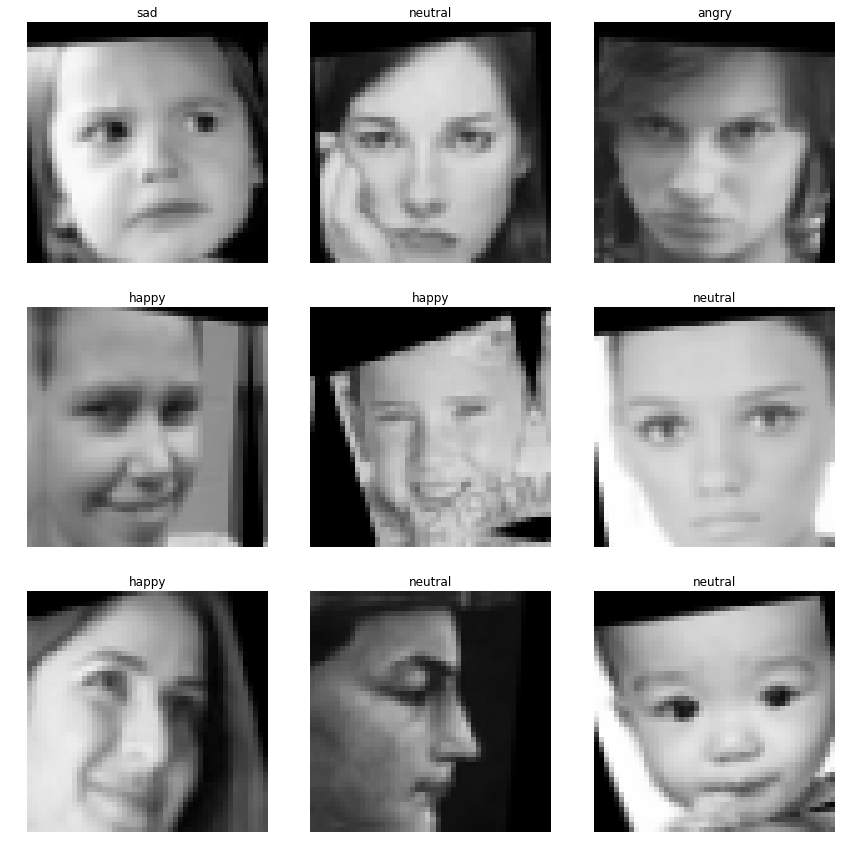

In [8]:
data.show_batch(rows=3)

## Init model

In [9]:
model = models.resnet18

In [10]:
learn = cnn_learner(data, model)

In [11]:
### THE DIRECTORY TO SAVE CHECKPOINTS
learn.model_dir = os.path.abspath(model_save_dir)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


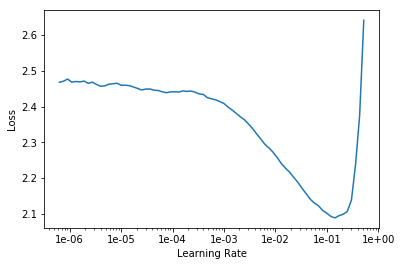

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
lr=5e-2

In [ ]:
learn.metrics = [accuracy]

## Start training

In [ ]:
learn.fit_one_cycle(12,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.591499,1.419581,0.460687,00:15
1,1.398888,1.241750,0.566911,00:15
2,1.218687,1.165405,0.619232,00:14
3,1.136158,0.976928,0.655599,00:14
4,1.057886,0.943186,0.674429,00:14
5,1.010329,0.945780,0.670404,00:16
6,0.960177,0.873995,0.689378,00:16
7,0.905485,0.829144,0.706483,00:15
8,0.876175,0.810636,0.706483,00:16
9,0.841559,0.792426,0.718126,00:15


In [ ]:
#learn.fit(12,lr)

In [ ]:
learn.save('stage-1')

#### Unfreeze 

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


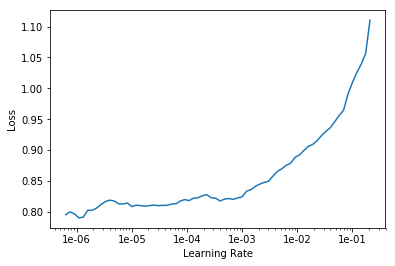

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-5

In [ ]:
#learn.fit_one_cycle(20,slice(lr))

In [ ]:
learn.fit(50)

epoch,train_loss,valid_loss,accuracy,time
0,0.807573,0.751432,0.729481,00:15
1,0.726865,0.762730,0.725744,00:15
2,0.665182,0.662762,0.764122,00:16
3,0.631666,0.638944,0.767572,00:15
4,0.598258,0.621765,0.767572,00:14
5,0.574259,0.663481,0.768147,00:14
6,0.549558,0.622935,0.781802,00:15
7,0.534372,0.586213,0.788127,00:16
8,0.511056,0.572959,0.802070,00:15
9,0.495310,0.566221,0.801639,00:15


In [ ]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (24336 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split;

Valid: LabelList (6957 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: CategoryList
angry,angry,angry,angry,angry
Path: /home/qnkhuat/data/emotion_compilation_split;

Test: LabelList (3479 items)
x: ImageList
Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48),Image (3, 48, 48)
y: EmptyLabelList
,,,,
Path: /home/qnkhuat/data/emotion_compilation_split, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation

In [ ]:
learn.fit(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.813753,0.728293,0.731925,00:15
1,0.724937,0.715021,0.731493,00:16
2,0.663679,0.665137,0.760242,00:15
3,0.625754,0.615209,0.775047,00:17


In [ ]:
learn.save('stage-2')

#### Refreeze

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(4)

In [ ]:
learn.save('stage-4')

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit(5,lr=1e-6)

In [ ]:
learn.save('stage-5')

In [ ]:
accuracy(*learn.TTA())

In [ ]:
# html_file_path = pjoin(model_save_dir,'fastai_resnet18.html')
os.system(f"jupyter nbconvert {get_notebook_name()} --output-dir {model_save_dir}")
model_save_dir